# Inference with missing data
Predict using partial candidate data as input using MICE imputation, and explain outputs with SHAP explainer.

In [21]:
import sys
sys.path.insert(0, '..')

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
import seaborn as sns
from joblib import load
from shap import Explanation, plots
from tqdm.auto import trange
from numpy.typing import ArrayLike

In [2]:
# Load pickled MICE model
with open('../mice.model', 'rb') as file:
    mice = load(file)

# Load pickled survival model
with open('../sCJDSurvEnsemble.model', 'rb') as file:
    ensemble = load(file)

## Missing Data Input

In [3]:
# Custom function for candidate data
def candidate(
    sex, ageonset, codon129,
    csfprot, rtquic, csf1433, s100b,
    mriimp, bg, thalamus, cortical, EEG,
    myoclonus, visual, cerebellar, pyramidal, expyramidal,
    akinetic_mutism, cognitive, psychiatric, behave
): 
    args = {
        'sex': sex, 'ageonset': ageonset, 'duration_m':np.nan, 'status': True, 'codon129': codon129,
        'csfprot': csfprot, 'rtquic': rtquic, 'csf1433': csf1433, 's100b': s100b,
        'mriimp':mriimp, 'bg': bg, 'thalamus': thalamus, 'cortical': cortical, 'EEG': EEG,
        'myoclonus': myoclonus, 'visual': visual, 'cerebellar': cerebellar, 'pyramidal': pyramidal, 'expyramidal': expyramidal,
        'akinetic_mutism': akinetic_mutism, 'cognitive': cognitive, 'psychiatric': psychiatric, 'behave': behave
    }
    
    data = pd.Series(args)

    binary_feats = ['bg', 'thalamus', 'myoclonus', 'visual', 'cerebellar',
                    'pyramidal', 'expyramidal', 'akinetic_mutism', 'cognitive',
                    'psychiatric', 'behave']

    # Replace boolean values with Y/N to match original data
    binary_data = data[binary_feats]
    binary_data.replace(True, 'Y', inplace=True)
    binary_data.replace(False, 'N', inplace=True)
    data.drop(binary_feats, inplace=True)
    data = pd.concat([data, binary_data])
    data = pd.DataFrame(data).T
    
    # Set continuous columns as float
    data[['ageonset','s100b', 'cortical', 'csfprot']] = data[['ageonset','s100b', 'cortical', 'csfprot']].astype('float64')
    
    # Order columns to match MICE model
    data = data[['sex', 'ageonset', 'duration_m', 'status', 'codon129', 'csfprot',
       'rtquic', 'csf1433', 's100b', 'mriimp', 'bg', 'thalamus', 'cortical',
       'EEG', 'myoclonus', 'visual', 'cerebellar', 'pyramidal', 'expyramidal',
       'akinetic_mutism', 'cognitive', 'psychiatric', 'behave']]
    
    # Set correct column data types
    data['status'] = data['status'].astype(bool)
    data[['ageonset', 'duration_m', 'csfprot', 's100b', 'cortical']] = data[['ageonset', 'duration_m', 'csfprot', 's100b', 'cortical']].astype('float64')
    
    # Set categoical columns and categories
    object_cols = data.dtypes[data.dtypes == object].index.tolist()
    for col in object_cols:
        data[col] = data[col].astype('category')
    
    # Add categories
    data.sex = data.sex.cat.set_categories(['Female', 'Male'])
    data.codon129 = data.codon129.cat.set_categories(['MM', 'MV', 'VV'])
    data.rtquic = data.rtquic.cat.set_categories(['NEG', 'POS'])
    data.csf1433 = data.csf1433.cat.set_categories(['NEG', 'POS'])
    data.EEG = data.EEG.cat.set_categories(['NEG', 'POS'])
    data.mriimp = data.mriimp.cat.set_categories(['N', 'P', 'S'])
    
    for col in ['bg', 'thalamus', 'myoclonus', 'visual' , 'cerebellar', 'pyramidal', 'expyramidal', 'akinetic_mutism', 'cognitive', 'psychiatric', 'behave']:
        data[col] = data[col].cat.set_categories(['N', 'Y'])
    
    return data

In [4]:
# Mark missing entries with np.nan

data = candidate(
    sex='Male',
    ageonset=56,
    codon129='MM',
    csfprot=np.nan,
    rtquic='POS',
    csf1433=np.nan,
    s100b=np.nan,
    mriimp='P',
    bg='Y',
    thalamus='Y',
    cortical=5,
    EEG=np.nan,
    myoclonus='Y',
    visual='N',
    cerebellar=np.nan,
    pyramidal='Y',
    expyramidal='Y',
    akinetic_mutism='N',
    cognitive='N',
    psychiatric='Y',
    behave='N'
)

# Imuptation


In [5]:
mice_infer = mice.impute_new_data(data)
mice_infer_data = [mice_infer.complete_data(i) for i in range(mice_infer.dataset_count())]

# Predict

In [15]:
# Pair-wise predict with newly imputed data
surv_dfs = [ensemble.ensemble[i].predict_surv_df(mice_infer_data[i])[0] for i in range(10)]

# Results
Median survival

In [49]:
def median_survival(surv_df):
    median_surv = (surv_df-0.5).abs().sort_values().index[0]
    return median_surv

# Calculate median survival
median_survs = [median_survival(surv_df) for surv_df in surv_dfs]
median_surv = np.mean(median_survs)

print(f'Mean median survival: {median_surv:.2f} months')

Mean median survival: 3.10 months


In [68]:
fig_dfs = pd.concat(surv_dfs, axis=1)
fig_dfs.columns = list(range(10))

fig_dfs = fig_dfs.T.melt(var_name='Month', value_name='Survival Probability')

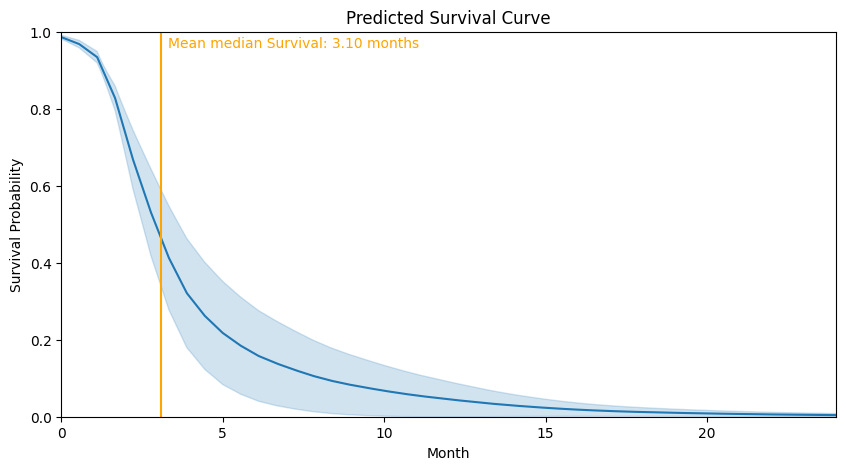

In [73]:
# Survival Curve
plt.figure(figsize=(10,5))

fig = sns.lineplot(
    data=fig_dfs,
    x='Month',
    y='Survival Probability',
    errorbar=('sd'),
)

fig.set(
    xlabel='Month',
    ylabel='Survival Probability',
    ylim=(0,1),
    xlim=(0,24),
    title='Predicted Survival Curve'
)

# fig.axvline(x=acutal_surv, color='green')
fig.axvline(x=median_surv, color='orange')
fig.text(median_surv+0.2, 0.96, f'Mean median Survival: {median_surv:.2f} months', color='orange')

plt.show()